# Notebook Notebook_29042020
The fourth notebook in the series of the Master Thesis of Robert Sietsma. This notebook is mostly dedicated to the Enrichr analysis. Also hosts the first idea of the analysis of the clinical gene panels.

In [2]:
# Importing some shizzle.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import time
import requests
import datetime
import sys
import os
import pathlib
import seaborn as sns
from sklearn.metrics import roc_auc_score
import math
import json
import glob
import xlrd3 as xlrd
import gzip
from utilities import perform_stats, calc_z_scores,\
    get_enrichr_results, plot_results,\
    plot_results_in_singleplot, plot_results_in_singleplot_iteractive_legend,\
    count_words_in_df, plot_count_results, split_and_count_words

# Defining some import and export locations
location = 'rjsietsma'
read_loc = '/home/'+location+'/shared/'
data_expor_loc = '/home/'+location+'/Documents/School/Master_DSLS/Final_Thesis/Past_initial_data/'
img_output_dir = '/home/'+location+'/PycharmProjects/dsls_master_thesis/side_scripts/output_img/'

In [3]:
# Some bokeh stuff

from bokeh.plotting import figure, ColumnDataSource, output_file, show, save
from bokeh.models import HoverTool, WheelZoomTool, PanTool,\
    BoxZoomTool, ResetTool, TapTool, SaveTool, FactorRange, Legend
from bokeh.palettes import inferno, Spectral5, viridis, Colorblind
from bokeh.transform import factor_cmap

# Enrichr automated API

In [3]:
enrichr_url = 'http://amp.pharm.mssm.edu/Enrichr/'

In [4]:
# Load in initial data
data = pd.read_csv('./datafiles/optimal_f1_full_ds_v2.csv', header=0)
data.rename(columns={
    'default_auc': 'auc'
}, inplace=True)
data.sort_values(by='default_f1', ascending=False)

,gene,auc,default_f1,default_recall,default_fpr,default_spec,optimal_c,optimal_auc,optimal_f1,optimal_recall,optimal_fpr,optimal_spec,n_tot,n_benign,n_malign
2775,PRKN,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,1.0,0.0,1.0,11,7,4
1659,BUB1B,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,1.0,0.0,1.0,73,66,7
2102,GALNT3,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,1.0,0.0,1.0,12,10,2
1655,PNPLA1,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,0.8,0.2,0.8,31,26,5
2782,TMEM80,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,1.0,0.0,1.0,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,C10orf2,0.469697,0.0,0.0,1.0,0.0,0.020,0.469697,0.000000,0.0,1.0,0.0,133,132,1
2330,SPTLC2,0.455157,0.0,0.0,1.0,0.0,0.011,0.750374,0.170213,0.0,1.0,0.0,229,223,6
2615,PLCD1,0.500000,0.0,0.0,1.0,0.0,0.020,0.500000,0.000000,0.0,1.0,0.0,8,7,1
2611,UBE2A,0.500000,0.0,0.0,1.0,0.0,0.020,0.500000,0.000000,0.0,1.0,0.0,3,2,1


In [5]:
data.shape[0]

2807

In [6]:
# data[['n_tot', 'n_benign', 'n_malign']].sum()

In [7]:
# Make a dictionary of lists of genes of interest with as key the 0.x threshold

auc_dict = {}
thresholds = np.arange(0.5, 1.01, 0.05).round(decimals=2)
for t in thresholds:
    list_of_genes = data[data['auc'] < t]['gene'].tolist()
    auc_dict[t.astype('str')] = '\n'.join(list_of_genes)
    del list_of_genes
del thresholds

# Save it to a file so I don't bombard the Enrichr API with requests
if not os.path.isfile('./user_id_list.json'):
    file = open('./user_id_list.json', 'w')
    file.close()

with open('./user_id_list.json') as json_file:
    try:
        user_list_ids = json.load(json_file)
        json_was_empty = False
    except json.JSONDecodeError:
        user_list_ids = {}
        json_was_empty = True

In [8]:
# Get list ID's for the different AUC's

for threshold in auc_dict.keys():
    if threshold not in user_list_ids.keys():
        description = f'CAPICE performance of genes with an AUC lower than {threshold}'
        payload = {
            'list': (None, auc_dict[threshold]),
            'description': (None, description)
        }
        response = requests.post(enrichr_url + '/addList', files=payload)
        if not response.ok:
            print(f'Something went wrong with {threshold}!')
        else:
            enrichr_addlist_response = json.loads(response.text)
            user_list_ids[threshold] = enrichr_addlist_response['userListId']

# Write it to a file in case I didn't have any.
if json_was_empty:
    with open('./user_id_list.json', 'w') as json_file:
        json.dump(user_list_ids, json_file)

In [9]:
# Now to get the enrichment results.

enrichr_sources_oi = ['BioPlanet_2019', 'WikiPathways_2019_Human', 'KEGG_2019_Human', 'Elsevier_Pathway_Collection',
                     'GO_Biological_Process_2018','Human_Phenotype_Ontology','Jensen_DISEASES',
                     'PheWeb_2019', 'ClinVar_2019', 'GWAS_Catalog_2019', 'DisGeNET','OMIM_Disease','OMIM_Expanded',
                     'Human_Gene_Atlas', 'ARCHS4_Tissues',
                     'HMDB_Metabolites','Chromosome_Location_hg19']


In [10]:
output_source_link = {}
for source in enrichr_sources_oi:
    output_filename = source + '.csv'
    output_source_link[source] = output_filename

In [11]:
glob_files_present = glob.glob('./EnrichrAPIResults/*.csv')
list_of_files_present = []
if len(glob_files_present) > 0:
    for file in glob_files_present:
        list_of_files_present.append(file.split('/')[-1])

In [12]:
sources_required = []
for source, output_filename in output_source_link.items():
    if output_filename not in list_of_files_present:
        sources_required.append(source)

In [13]:
sources_required

[]

In [14]:
get_enrichr_results(sources_required, user_list_ids, 20)

You should give some sources for me to get data from.


In [15]:
enrichr_data_loc = './EnrichrAPIResults/'

enrichr_dataset = {}

for source in enrichr_sources_oi:
    dataset = enrichr_data_loc + source + '.csv'
    enrichr_dataset[source] = pd.read_csv(dataset)

In [16]:
enrichr_dataset['BioPlanet_2019'].head()

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,3,Activation of TRKA receptors,NTRK2,1.0,BioPlanet_2019
1,0.5,4,MAP kinase pathway regulation through dual spe...,DUSP6,1.0,BioPlanet_2019
2,0.5,5,ERK inactivation,DUSP6,1.0,BioPlanet_2019
3,0.5,7,Nucleotide-like (purinergic) G-protein coupled...,P2RY12,1.0,BioPlanet_2019
4,0.5,8,Gap junction assembly,GJB3,1.0,BioPlanet_2019


In [17]:
for key in enrichr_dataset.keys():
    plot = plot_results(enrichr_dataset[key], 10)
    save(plot)

In [39]:
combined_df = pd.DataFrame(columns=enrichr_dataset['BioPlanet_2019'].columns)
for key, value in enrichr_dataset.items():
    subdf = pd.DataFrame(columns=combined_df.columns)
    for auc in value['AUC'].unique():
        subdf = subdf.append(value[value['AUC'] == auc][:10], ignore_index=True)
    combined_df = combined_df.append(subdf, ignore_index=True)
combined_df

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,3,Activation of TRKA receptors,NTRK2,1.0,BioPlanet_2019
1,0.5,4,MAP kinase pathway regulation through dual spe...,DUSP6,1.0,BioPlanet_2019
2,0.5,5,ERK inactivation,DUSP6,1.0,BioPlanet_2019
3,0.5,7,Nucleotide-like (purinergic) G-protein coupled...,P2RY12,1.0,BioPlanet_2019
4,0.5,8,Gap junction assembly,GJB3,1.0,BioPlanet_2019
...,...,...,...,...,...,...
1804,1.0,8,chr16,"CTCF, LITAF, PKD1, SALL1, CDH1, TUBB3, CHMP1A,...",1.0,Chromosome_Location_hg19
1805,1.0,6,chr6 mcf hap5,"TNXB, CYP21A2, TUBB, COL11A2, SKIV2L, VARS2, C...",1.0,Chromosome_Location_hg19
1806,1.0,9,chr15,"GABRB3, MTFMT, HEXA, ETFA, UBE3A, CHD2, NR2E3,...",1.0,Chromosome_Location_hg19
1807,1.0,7,chr6 dbb hap3,"TNXB, CYP21A2, TUBB, COL11A2, SKIV2L, VARS2, C...",1.0,Chromosome_Location_hg19


In [40]:
combined_df.head(20)

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.50,3,Activation of TRKA receptors,NTRK2,1.0,BioPlanet_2019
1,0.50,4,MAP kinase pathway regulation through dual spe...,DUSP6,1.0,BioPlanet_2019
2,0.50,5,ERK inactivation,DUSP6,1.0,BioPlanet_2019
3,0.50,7,Nucleotide-like (purinergic) G-protein coupled...,P2RY12,1.0,BioPlanet_2019
4,0.50,8,Gap junction assembly,GJB3,1.0,BioPlanet_2019
5,0.50,9,Interleukin-11 pathway,DUSP6,1.0,BioPlanet_2019
6,0.50,10,ADP signalling through P2Y purinoceptor 12,P2RY12,1.0,BioPlanet_2019
7,0.50,11,Gap junction trafficking and regulation,GJB3,1.0,BioPlanet_2019
8,0.50,12,Nuclear events mediated by MAP kinases,DUSP6,1.0,BioPlanet_2019
9,0.50,13,Signal amplification,P2RY12,1.0,BioPlanet_2019


In [41]:
plot = plot_results_in_singleplot_iteractive_legend(combined_df)
save(plot)

'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/EnrichrAPIResults/combined_enrichr_plot_results_interactive_legend.html'

In [42]:
plot = plot_results_in_singleplot(combined_df)
save(plot)

'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/EnrichrAPIResults/combined_enrichr_plot_results.html'

## Interpretation
It seems that a normal distribution like pattern is formed with a steeper slope after the maximum, starting at rougly AUC of 0.3 and ending at roughly 0.8.
<br/><br/>
- DisGeNET seems to outline an interesting picture with the top 10 term names:
    - For it seems that in the really bad performing genes the main cause could be infant development related. Later on, more neurological causes are identified.
        - Neurological seems clear to me... There is still so much unknown about the human mind.
        - Infant development related is a bit less clear, since there is a growing amount of research towards this infant development.
- GO_biological_process seems to have primarily the same genes for AUC 0.55-0.7 that are most enriched
    - It seems linked to ion channeling
- Feet and toe abnormalities seem to occur once or twice too
- Could this be an indication to genes that are related to very small molecules? (like steroids, ions, neuro-molecules?)
- Most significant: autosomal dominant inheritence
    - Very interesting plot, the HPO bokeh plot of n=10
- 

<br/><br/>
TODO: make word counts of genes and term names?


In [43]:
combined_df_ext = pd.DataFrame(columns=enrichr_dataset['BioPlanet_2019'].columns)
for key, value in enrichr_dataset.items():
    subdf = pd.DataFrame(columns=combined_df_ext.columns)
    for auc in value['AUC'].unique():
        subdf = subdf.append(value[value['AUC'] == auc], ignore_index=True)
    combined_df_ext = combined_df_ext.append(subdf, ignore_index=True)
combined_df_ext

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,3,Activation of TRKA receptors,NTRK2,1.0,BioPlanet_2019
1,0.5,4,MAP kinase pathway regulation through dual spe...,DUSP6,1.0,BioPlanet_2019
2,0.5,5,ERK inactivation,DUSP6,1.0,BioPlanet_2019
3,0.5,7,Nucleotide-like (purinergic) G-protein coupled...,P2RY12,1.0,BioPlanet_2019
4,0.5,8,Gap junction assembly,GJB3,1.0,BioPlanet_2019
...,...,...,...,...,...,...
3359,1.0,17,chr22,"SMARCB1, TMPRSS6, PDGFB, TCF20, PLA2G6, TYMP, ...",1.0,Chromosome_Location_hg19
3360,1.0,16,chr6 cox hap2,"TNXB, CYP21A2, TUBB, COL11A2, SKIV2L, VARS2, C...",1.0,Chromosome_Location_hg19
3361,1.0,18,chr21,"COL18A1, KCNE2, TMPRSS3, ITGB2, DYRK1A, TSPEAR...",1.0,Chromosome_Location_hg19
3362,1.0,20,chr3,"SETD5, SETD2, GFM1, ZBTB20, PLOD2, SLC6A1, MYL...",1.0,Chromosome_Location_hg19


In [44]:
combined_df_ext.where((combined_df_ext['AUC'] == 0.5) & (combined_df_ext['Source'] == 'BioPlanet_2019')).dropna()

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,3,Activation of TRKA receptors,NTRK2,1.0,BioPlanet_2019
1,0.5,4,MAP kinase pathway regulation through dual spe...,DUSP6,1.0,BioPlanet_2019
2,0.5,5,ERK inactivation,DUSP6,1.0,BioPlanet_2019
3,0.5,7,Nucleotide-like (purinergic) G-protein coupled...,P2RY12,1.0,BioPlanet_2019
4,0.5,8,Gap junction assembly,GJB3,1.0,BioPlanet_2019
5,0.5,9,Interleukin-11 pathway,DUSP6,1.0,BioPlanet_2019
6,0.5,10,ADP signalling through P2Y purinoceptor 12,P2RY12,1.0,BioPlanet_2019
7,0.5,11,Gap junction trafficking and regulation,GJB3,1.0,BioPlanet_2019
8,0.5,12,Nuclear events mediated by MAP kinases,DUSP6,1.0,BioPlanet_2019
9,0.5,13,Signal amplification,P2RY12,1.0,BioPlanet_2019


In [45]:
word_count_df = count_words_in_df(combined_df_ext)

In [46]:
nwkdf = pd.DataFrame(columns=word_count_df.columns)
for auc in word_count_df['auc'].unique():
    nwkdf = nwkdf.append(word_count_df[word_count_df['auc'] == auc][:5])
nwkdf

,word,count,auc
0,signaling,19,0.50
1,pathway,14,0.50
2,disease,9,0.50
3,syndrome,9,0.50
4,(bulk,9,0.50
498,signaling,13,0.55
499,pathway,10,0.55
500,disease,10,0.55
501,regulation,9,0.55
502,syndrome,9,0.55


In [47]:
plot = plot_count_results(nwkdf, item='word')
save(plot)

'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/EnrichrAPIResults/enrichr_word_count_bokeh.html'

In [48]:
gene_count_df = pd.DataFrame(columns=['gene', 'count', 'auc'])
for auc in combined_df_ext['AUC'].unique():
    subset_df = combined_df_ext[combined_df_ext['AUC'] == auc]
    gene_list = []
    unsplitted_gene_list = subset_df['Overlapping_Genes'].tolist()
    for unsplitted_gene in unsplitted_gene_list:
        gene_list += unsplitted_gene.split(', ')
    gene_count_dict = {}
    for gene in gene_list:
        if gene not in gene_count_dict.keys():
            gene_count_dict[gene] = 1
        else:
            gene_count_dict[gene] += 1
    temp_df = pd.DataFrame(columns=gene_count_df.columns)
    for key in gene_count_dict.keys():
        temp_temp_df = pd.DataFrame({'gene':key, 'count': gene_count_dict[key],
                                    'auc': auc}, index=[0])
        temp_df = temp_df.append(temp_temp_df, ignore_index=True)
    gene_count_df = gene_count_df.append(temp_df, ignore_index=True)

In [49]:
gene_count_df.sort_values(by=['auc','count'], ascending=[True, False], inplace=True)

In [50]:
ngkdf = pd.DataFrame(columns=gene_count_df.columns)
for auc in gene_count_df['auc'].unique():
    ngkdf = ngkdf.append(gene_count_df[gene_count_df['auc'] == auc][:5])

In [51]:
plot = plot_count_results(ngkdf, item='gene')
save(plot)

'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/EnrichrAPIResults/enrichr_gene_count_bokeh.html'

In [52]:
combined_df_ext = pd.DataFrame(columns=enrichr_dataset['BioPlanet_2019'].columns)
for key, value in enrichr_dataset.items():
    subdf = pd.DataFrame(columns=combined_df_ext.columns)
    for auc in value['AUC'].unique():
        subdf = subdf.append(value[value['AUC'] == auc], ignore_index=True)
    combined_df_ext = combined_df_ext.append(subdf, ignore_index=True)
combined_df_ext

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,3,Activation of TRKA receptors,NTRK2,1.0,BioPlanet_2019
1,0.5,4,MAP kinase pathway regulation through dual spe...,DUSP6,1.0,BioPlanet_2019
2,0.5,5,ERK inactivation,DUSP6,1.0,BioPlanet_2019
3,0.5,7,Nucleotide-like (purinergic) G-protein coupled...,P2RY12,1.0,BioPlanet_2019
4,0.5,8,Gap junction assembly,GJB3,1.0,BioPlanet_2019
...,...,...,...,...,...,...
3359,1.0,17,chr22,"SMARCB1, TMPRSS6, PDGFB, TCF20, PLA2G6, TYMP, ...",1.0,Chromosome_Location_hg19
3360,1.0,16,chr6 cox hap2,"TNXB, CYP21A2, TUBB, COL11A2, SKIV2L, VARS2, C...",1.0,Chromosome_Location_hg19
3361,1.0,18,chr21,"COL18A1, KCNE2, TMPRSS3, ITGB2, DYRK1A, TSPEAR...",1.0,Chromosome_Location_hg19
3362,1.0,20,chr3,"SETD5, SETD2, GFM1, ZBTB20, PLOD2, SLC6A1, MYL...",1.0,Chromosome_Location_hg19


In [53]:
combined_df_ext.where((combined_df_ext['AUC'] == 0.5) & (combined_df_ext['Source'] == 'BioPlanet_2019')).dropna()

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,3,Activation of TRKA receptors,NTRK2,1.0,BioPlanet_2019
1,0.5,4,MAP kinase pathway regulation through dual spe...,DUSP6,1.0,BioPlanet_2019
2,0.5,5,ERK inactivation,DUSP6,1.0,BioPlanet_2019
3,0.5,7,Nucleotide-like (purinergic) G-protein coupled...,P2RY12,1.0,BioPlanet_2019
4,0.5,8,Gap junction assembly,GJB3,1.0,BioPlanet_2019
5,0.5,9,Interleukin-11 pathway,DUSP6,1.0,BioPlanet_2019
6,0.5,10,ADP signalling through P2Y purinoceptor 12,P2RY12,1.0,BioPlanet_2019
7,0.5,11,Gap junction trafficking and regulation,GJB3,1.0,BioPlanet_2019
8,0.5,12,Nuclear events mediated by MAP kinases,DUSP6,1.0,BioPlanet_2019
9,0.5,13,Signal amplification,P2RY12,1.0,BioPlanet_2019


In [54]:
word_count_df = count_words_in_df(combined_df_ext)

In [55]:
nwkdf = pd.DataFrame(columns=word_count_df.columns)
for auc in word_count_df['auc'].unique():
    nwkdf = nwkdf.append(word_count_df[word_count_df['auc'] == auc][:5])
nwkdf

,word,count,auc
0,signaling,19,0.50
1,pathway,14,0.50
2,disease,9,0.50
3,syndrome,9,0.50
4,(bulk,9,0.50
498,signaling,13,0.55
499,pathway,10,0.55
500,disease,10,0.55
501,regulation,9,0.55
502,syndrome,9,0.55


In [56]:
plot = plot_count_results(nwkdf, item='word')
save(plot)

'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/EnrichrAPIResults/enrichr_word_count_bokeh.html'

In [57]:
gene_count_df = pd.DataFrame(columns=['gene', 'count', 'auc'])
for auc in combined_df_ext['AUC'].unique():
    subset_df = combined_df_ext[combined_df_ext['AUC'] == auc]
    gene_list = []
    unsplitted_gene_list = subset_df['Overlapping_Genes'].tolist()
    for unsplitted_gene in unsplitted_gene_list:
        gene_list += unsplitted_gene.split(', ')
    gene_count_dict = {}
    for gene in gene_list:
        if gene not in gene_count_dict.keys():
            gene_count_dict[gene] = 1
        else:
            gene_count_dict[gene] += 1
    temp_df = pd.DataFrame(columns=gene_count_df.columns)
    for key in gene_count_dict.keys():
        temp_temp_df = pd.DataFrame({'gene':key, 'count': gene_count_dict[key],
                                    'auc': auc}, index=[0])
        temp_df = temp_df.append(temp_temp_df, ignore_index=True)
    gene_count_df = gene_count_df.append(temp_df, ignore_index=True)

In [58]:
gene_count_df.sort_values(by=['auc','count'], ascending=[True, False], inplace=True)

In [59]:
ngkdf = pd.DataFrame(columns=gene_count_df.columns)
for auc in gene_count_df['auc'].unique():
    ngkdf = ngkdf.append(gene_count_df[gene_count_df['auc'] == auc][:5])

In [60]:
plot = plot_count_results(ngkdf, item='gene')
save(plot)

'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/EnrichrAPIResults/enrichr_gene_count_bokeh.html'

## Interpretation
It seems that a normal distribution like pattern is formed with a steeper slope after the maximum, starting at rougly AUC of 0.3 and ending at roughly 0.8.
<br/><br/>
- DisGeNET seems to outline an interesting picture with the top 10 term names:
    - For it seems that in the really bad performing genes the main cause could be infant development related. Later on, more neurological causes are identified.
        - Neurological seems clear to me... There is still so much unknown about the human mind.
        - Infant development related is a bit less clear, since there is a growing amount of research towards this infant development.
- GO_biological_process seems to have primarily the same genes for AUC 0.55-0.7 that are most enriched
    - It seems linked to ion channeling
- Feet and toe abnormalities seem to occur once or twice too
- Could this be an indication to genes that are related to very small molecules? (like steroids, ions, neuro-molecules?)
- Most significant: autosomal dominant inheritence
    - Very interesting plot, the HPO bokeh plot of n=10
- 

<br/><br/>
TODO: make word counts of genes and term names?


# Correlation analysis Enrichr results
Investigate the interactive legend.

- Bioplanet 2019:
    - Anticorrelation possible, high adjusted-pvalue (APV) when auc is low, but low APV when AUC is high.
    
- Wikipathways:
    - Shows simular anticorrelation to bioplanet, but peaks at 0.55 auc. Could be a normal distribution like.
    
- Kegg 2019:
    - Pretty much all over the place. Some significant when low AUC, but also some not significant. Seems like 2 different distributions are present. One distribution is a linear like from auc 0.5 apv 0.2 to auc 0.7 apv 0.6, but above that a normally distributed curve. Interesting, investigate futher.
    
- Elsevier:
    - Clear normal distribution like, with a peak at either 0.55 (everything is not significant) or 0.65 (largely not significant).

- GO Biological:
    - Similar to kegg, 2 distributions might be shown. A normal distribution like and an inverse exponent. Both seem to be crossing each other at auc 0.5 APV 0.4.

- HPO:
    - Is low and stays low. Tops at auc 0.55 and APV 0.15. Always significant.

- Jensen Diseases:
    - Not really following any distribution. Got some significant, some not and some in between. Tops at auc 0.55 and APV 1.
    
- PheWeb:
    - Exponentially correlated. "Low" when auc is low, get higher when AUC get higher up to auc 0.95 where it becomes more significant.
    
- Clinvar:
    - Multiple distributions present. One 'high' and one 'low'. Investigate futher.
    
- GWAS catalogue:
    - Maybe anti-correlated with some outliers?
    
- DisGeNet:
    - Always significant, simular to HPO.
    
- Omim Disease:
    - Anti-correlated with some points that are always significant.
    
- Omim expanded:
    - Not following omim disease pattern, more like a normal distribution that peaks at auc 0.7 APV 0.6.
    
- Human gene atlas:
    - Like a half cosinus wave with a very sudden drop at auc 0.8.
    
- ARCHS4 tissues:
    - Normal distribution like that tops over APV of 1 at AUC 0.65.
    
- HMDB Metabolites:
    - Says insigificant up untill auc 0.75, where it drops steeply.
    
- Chromosome location:
    - Always insigificant untill AUC 0.85, where chromosome X is always significant.
    
    
# AUC cutoffs where there is still some variation

- Bioplanet: 0.85

- Wikipathways: 0.85

- Kegg: 0.85

- Elsevier pathway collection: 0.80

- GO Biological: 0.80

- HPO: 0.75

- Jensen DISEASES: 0.80

- PheWEB: 0.7 (after that some points become more significant again, but that is commonly seen throughout every database)

- ClinVar: 0.85

- GWAS Catalogue: 0.9

- DisGeNET: 0.7

- OMIM_Disease: 0.85

- OMIM_Expanded: 0.80

- Human Gene Atlas: 0.95

- ARCHS4 tissues: 0.9

- HMDB Metabolites: 0.9

- Chromosome location: Odd one out (always insignificant except for auc 0.9-1.0 where chromosome X becomes significant)


 


In [65]:
combined_df_ext.head()

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,3,Activation of TRKA receptors,NTRK2,1.0,BioPlanet_2019
1,0.5,4,MAP kinase pathway regulation through dual spe...,DUSP6,1.0,BioPlanet_2019
2,0.5,5,ERK inactivation,DUSP6,1.0,BioPlanet_2019
3,0.5,7,Nucleotide-like (purinergic) G-protein coupled...,P2RY12,1.0,BioPlanet_2019
4,0.5,8,Gap junction assembly,GJB3,1.0,BioPlanet_2019


In [64]:
for source in combined_df_ext['Source'].unique():
    subset = combined_df_ext[combined_df_ext['Source'] == source]
    subset = subset.groupby(by='AUC').mean()
    rho, pval = stats.spearmanr(subset.index, subset['Adjusted_P-value'])
    print(f'Correlation coefficient for {source} is:{rho}')
    print(f'P-value of {source} is: {pval}')
    if pval >= 0.05:
        print(f'Fail to reject null hypothesis of {source} being uncorrelated, meaning they are uncorrelated.\n')
    else:
        print(f'Able to reject null hypothesis of {source} being uncorrelated, there is a:')
        if rho > 0:
            print('positive correlation. \n')
        else:
            print('negative correlation. \n')

Correlation coefficient for BioPlanet_2019 is:-0.8991204081865278
P-value of BioPlanet_2019 is: 0.0001661839752544972
Able to reject null hypothesis of BioPlanet_2019 being uncorrelated, there is a:
negative correlation. 

Correlation coefficient for WikiPathways_2019_Human is:-0.6885583156948685
P-value of WikiPathways_2019_Human is: 0.019136081775021636
Able to reject null hypothesis of WikiPathways_2019_Human being uncorrelated, there is a:
negative correlation. 

Correlation coefficient for KEGG_2019_Human is:-0.6102160571171791
P-value of KEGG_2019_Human is: 0.046180632934565924
Able to reject null hypothesis of KEGG_2019_Human being uncorrelated, there is a:
negative correlation. 

Correlation coefficient for Elsevier_Pathway_Collection is:-0.9339431975353206
P-value of Elsevier_Pathway_Collection is: 2.6028693621417825e-05
Able to reject null hypothesis of Elsevier_Pathway_Collection being uncorrelated, there is a:
negative correlation. 

Correlation coefficient for GO_Biologica

In [77]:
for source in combined_df_ext['Source'].unique():
    subset = combined_df_ext[combined_df_ext['Source'] == source]
    subset = subset.groupby(by='AUC').mean()
    rho, pval = stats.spearmanr(subset.index, subset['Adjusted_P-value'])
    print(subset)
    break
    print(f'Correlation coefficient for {source} is:{rho}')
    print(f'P-value of {source} is: {pval}')
    if pval >= 0.05:
        print(f'Fail to reject null hypothesis of {source} being uncorrelated, meaning they are uncorrelated.\n')
    else:
        print(f'Able to reject null hypothesis of {source} being uncorrelated, there is a:')
        if rho > 0:
            print('positive correlation. \n')
        else:
            print('negative correlation. \n')

      Adjusted_P-value
AUC                   
0.50      1.000000e+00
0.55      1.000000e+00
0.60      1.000000e+00
0.65      9.580241e-01
0.70      9.615924e-01
0.75      9.699334e-01
0.80      9.860955e-01
0.85      5.848485e-01
0.90      1.880091e-01
0.95      2.542807e-02
1.00      2.557615e-12


In [75]:
combined_df_ext

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,3,Activation of TRKA receptors,NTRK2,1.0,BioPlanet_2019
1,0.5,4,MAP kinase pathway regulation through dual spe...,DUSP6,1.0,BioPlanet_2019
2,0.5,5,ERK inactivation,DUSP6,1.0,BioPlanet_2019
3,0.5,7,Nucleotide-like (purinergic) G-protein coupled...,P2RY12,1.0,BioPlanet_2019
4,0.5,8,Gap junction assembly,GJB3,1.0,BioPlanet_2019
...,...,...,...,...,...,...
3359,1.0,17,chr22,"SMARCB1, TMPRSS6, PDGFB, TCF20, PLA2G6, TYMP, ...",1.0,Chromosome_Location_hg19
3360,1.0,16,chr6 cox hap2,"TNXB, CYP21A2, TUBB, COL11A2, SKIV2L, VARS2, C...",1.0,Chromosome_Location_hg19
3361,1.0,18,chr21,"COL18A1, KCNE2, TMPRSS3, ITGB2, DYRK1A, TSPEAR...",1.0,Chromosome_Location_hg19
3362,1.0,20,chr3,"SETD5, SETD2, GFM1, ZBTB20, PLOD2, SLC6A1, MYL...",1.0,Chromosome_Location_hg19


In [81]:
for term in combined_df_ext['Term_Name'].unique():
    subset = combined_df_ext[combined_df_ext['Term_Name'] == term]
    min_thres = subset['AUC'].min()
    max_thres = subset['AUC'].max()
    if min_thres == max_thres:
        continue
    data_source = subset['Source'].unique()[0]
    rho, pval = stats.spearmanr(subset['AUC'], subset['Adjusted_P-value'])
    if pval <= 0.05:
        if rho > 0:
            print(f"Source {data_source} has a significant positive correlation:")
            print(f"Term: {term}")
            print(f"p-value: {pval}")
            print(f"correlation coefficient: {rho}")
            print(f"Running from {min_thres} to {max_thres}")
            print("\n")

Source Jensen_DISEASES has a significant positive correlation:
Term: Ollier disease
p-value: 0.0
correlation coefficient: 1.0
Running from 0.75 to 0.85




In [46]:
pheweb = combined_df_ext.where((combined_df_ext['AUC'] <= 0.9) & (combined_df_ext['Source'] == 'PheWeb_2019')).dropna()

In [47]:
pheweb.index = pheweb.reindex(labels=np.arange(pheweb.shape[0]), axis=0).index
grouped_pheweb = pheweb.groupby(by='AUC').mean()
grouped_pheweb
rho, pval = stats.spearmanr(grouped_pheweb.index, grouped_pheweb['Adjusted_P-value'])
print(f'Correlation coefficient for pheweb is:{rho}')
print(f'P-value of pheweb is: {pval}')
if pval >= 0.05:
    print(f'Fail to reject null hypothesis of pheweb being uncorrelated, meaning they are uncorrelated.\n')
else:
    print(f'Able to reject null hypothesis of pheweb being uncorrelated, there is a:')
    if rho > 0:
        print('positive correlation. \n')
    else:
        print('negative correlation. \n')

Correlation coefficient for pheweb is:0.45643546458763845
P-value of pheweb is: 0.2168375456189006
Fail to reject null hypothesis of pheweb being uncorrelated, meaning they are uncorrelated.



In [48]:
# Both 0.7 and 0.9 state that PheWeb is positively correlated when AUC cutoff is left at 0.9.

In [49]:
kegg = combined_df_ext.where((combined_df_ext['AUC'] <= 0.85) & (combined_df_ext['Source'] == 'KEGG_2019_Human')).dropna()

In [50]:
kegg.index = kegg.reindex(labels=np.arange(kegg.shape[0]), axis=0).index
grouped_kegg = kegg.groupby(by='AUC').mean()
grouped_kegg
rho, pval = stats.spearmanr(grouped_kegg.index, grouped_kegg['Adjusted_P-value'])
print(f'Correlation coefficient for kegg is:{rho}')
print(f'P-value of kegg is: {pval}')
if pval >= 0.05:
    print(f'Fail to reject null hypothesis of kegg being uncorrelated, meaning they are uncorrelated.\n')
else:
    print(f'Able to reject null hypothesis of kegg being uncorrelated, there is a:')
    if rho > 0:
        print('positive correlation. \n')
    else:
        print('negative correlation. \n')

Correlation coefficient for kegg is:0.10910894511799618
P-value of kegg is: 0.7970385741881917
Fail to reject null hypothesis of kegg being uncorrelated, meaning they are uncorrelated.



In [51]:
# Further confirms that KEGG might have multiple distributions.

In [52]:
jensen_d = combined_df_ext.where((combined_df_ext['AUC'] <= 0.8) & (combined_df_ext['Source'] == 'Jensen_DISEASES')).dropna()

In [53]:
jensen_d.index = jensen_d.reindex(labels=np.arange(jensen_d.shape[0]), axis=0).index
grouped_jensen_d = jensen_d.groupby(by='AUC').mean()
rho, pval = stats.spearmanr(grouped_jensen_d.index, grouped_jensen_d['Adjusted_P-value'])
print(f'Correlation coefficient for jensen_d is:{rho}')
print(f'P-value of jensen_d is: {pval}')
if pval >= 0.05:
    print(f'Fail to reject null hypothesis of jensen_d being uncorrelated, meaning they are uncorrelated.\n')
else:
    print(f'Able to reject null hypothesis of jensen_d being uncorrelated, there is a:')
    if rho > 0:
        print('positive correlation. \n')
    else:
        print('negative correlation. \n')

Correlation coefficient for jensen_d is:-0.642857142857143
P-value of jensen_d is: 0.11939237342741094
Fail to reject null hypothesis of jensen_d being uncorrelated, meaning they are uncorrelated.



In [54]:
nlines = 0
temp_df = pd.DataFrame(columns=combined_df_ext.columns)
for pathway in combined_df_ext['Term_Name'].unique():
    nlines += 1
    subset = combined_df_ext[combined_df_ext['Term_Name'] == pathway]
    x = subset['AUC']
    y = subset['Adjusted_P-value']
    rho, pval = stats.spearmanr(x, y)
    if pval < 0.05 and rho > 0:
        temp_df = temp_df.append(subset, ignore_index=True)
second_word_count = count_words_in_df(temp_df)
second_word_count.sort_values(by='count', ascending=False).head(10)

/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,word,count,auc
0,ollier,1,0.75
1,disease,1,0.75
2,ollier,1,0.80
3,disease,1,0.80
4,ollier,1,0.85
5,disease,1,0.85


In [55]:
combined_df_ext['n_genes'] = combined_df_ext['Overlapping_Genes'].apply(lambda x: split_and_count_words(x))

In [56]:
nlines = 0
for pathway in combined_df_ext['Term_Name'].unique():
    nlines += 1
    subset = combined_df_ext[combined_df_ext['Term_Name'] == pathway]
    x = subset['AUC']
    y = subset['Adjusted_P-value']
    min_genes = subset['n_genes'].min()
    max_genes = subset['n_genes'].max()
    rho, pval = stats.spearmanr(x, y)
    if pval < 0.1 and rho > 0:
        genes = subset['Overlapping_Genes'].values.tolist()
        output_genes = []
        for gene in genes:
            intermediate_genes = split_and_count_words(gene, return_value = None)
            for g in intermediate_genes:
                if g not in output_genes:
                    output_genes.append(g)
        if len(output_genes) >= 3:
            output_genes = ', '.join(output_genes)
            print(f'Able to reject null hypothesis of {pathway} for AUC: '
                  f'{x.values[0]} - {x.values[-1]} and source: '
                  f'{subset["Source"].unique()[0]} for genes: {output_genes}')
            print('\n')

/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [57]:
interesting_pathway = ['Transfer RNA aminoacylation',
                        'Oxytocin signaling pathway',
                        'Tinnitus',
                        'Acne',
                        'COLONIC MUCOSA'
                      ]
for pathway in interesting_pathway:
    print(pathway)
    print(combined_df_ext[combined_df_ext['Term_Name'] == pathway])
    print('\n')

Transfer RNA aminoacylation
      AUC Rank                    Term_Name Overlapping_Genes  \
108  0.75    3  Transfer RNA aminoacylation        YARS, GARS   

     Adjusted_P-value          Source  n_genes  
108               1.0  BioPlanet_2019        2  


Oxytocin signaling pathway
Empty DataFrame
Columns: [AUC, Rank, Term_Name, Overlapping_Genes, Adjusted_P-value, Source, n_genes]
Index: []


Tinnitus
       AUC Rank Term_Name     Overlapping_Genes  Adjusted_P-value  \
1658  0.90   11  Tinnitus          TRPC6, AGBL1               1.0   
1668  0.95    2  Tinnitus  CACNB2, TRPC6, AGBL1               1.0   

           Source  n_genes  
1658  PheWeb_2019        2  
1668  PheWeb_2019        3  


Acne
       AUC Rank Term_Name Overlapping_Genes  Adjusted_P-value       Source  \
1583  0.70   18      Acne             NRXN3               1.0  PheWeb_2019   
1605  0.75   20      Acne             NRXN3               1.0  PheWeb_2019   

      n_genes  
1583        1  
1605        1  


COLO

In [62]:
nlines = 0
for pathway in combined_df_ext['Term_Name'].unique():
    nlines += 1
    subset = combined_df_ext[combined_df_ext['Term_Name'] == pathway]
    x = subset['AUC']
    y = subset['Adjusted_P-value']
    min_genes = subset['n_genes'].min()
    max_genes = subset['n_genes'].max()
    rho, pval = stats.spearmanr(x, y)
    if pval < 0.05 and rho > 0:
        genes = subset['Overlapping_Genes'].values.tolist()
        output_genes = []
        for gene in genes:
            intermediate_genes = split_and_count_words(gene, return_value = None)
            for g in intermediate_genes:
                if g not in output_genes:
                    output_genes.append(g)
        if len(output_genes) >= 3:
            output_genes = ', '.join(output_genes)
            print(f'Able to reject null hypothesis of {pathway} for AUC: '
                  f'{x.values[0]} - {x.values[-1]} and source: '
                  f'{subset["Source"].unique()[0]} for genes: {output_genes}')
            print('\n')

/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [59]:
combined_df_ext[combined_df_ext['Term_Name'] == 'Tinnitus']

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source,n_genes
1658,0.90,11,Tinnitus,"TRPC6, AGBL1",1.0,PheWeb_2019,2
1668,0.95,2,Tinnitus,"CACNB2, TRPC6, AGBL1",1.0,PheWeb_2019,3


In [60]:
combined_df_ext[combined_df_ext['Term_Name'].str.lower().str.startswith('brugada')]

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source,n_genes
1846,0.95,19,brugada syndrome,"CACNB2, CACNA1C",0.078511,ClinVar_2019,2


- Genes involved in identifying brugada syndrome might be troublesome for CAPICE, but then again, if we look at the command 'combined_df_ext[combined_df_ext['Term_Name'].str.lower().str.startswith('brugada')]' there's not a lot of genes in that.
- Colonic Mucosa is not really that interesting either. Starts at AUC 0.65 and ends at 0.75, only increasing slightly with an adjusted p-value of at least 0.999925 (very insignificant).
    - Transfer RNA aminoacylation is a bit different, still insignificant but starts at 0.594633.
    - Same goes for Oxytocin signaling pathway, starts at 0.941531
    - Tinnitus is a bit different, only has 2 genes in the lower AUC values but starts out at 0.218952 and goes up to 1 from auc 0.5-0.9.
    
    
- When a pad performing gene panels is found, make a decision tree on what to do next.
- Keep in mind, I have 4 times the amount of benign samples than malignant samples.
- Chi squared / regression correlation analysis between false positive / negative samples on a shared feature.
- Turning in concept verion paper on 6th of July is possible with the 2 weeks deadline for feedback. 
- All methods to seperate python files and then import them to clean up notebook.
- Phase 2 will produce graphs, order them to the story I want to tell.
    - Thesis is a bit more than a paper, but a bit less than a bachelor

# First concept of the clinical gene panel analysis

In [7]:
auc_data = data[['gene','auc']].copy()

In [8]:
auc_data.set_index('gene', inplace=True)

In [9]:
auc_data

,auc
gene,
RDH12,0.839161
EIF2AK4,0.981481
EIF2AK3,0.966667
PRKAG2,0.981203
JAG1,0.925388
...,...
FLG2,1.000000
ACOX2,1.000000
SLITRK4,1.000000


In [10]:
x = auc_data.index.values
x2 = auc_data['auc'].values
auc_data_series = pd.Series(x2, index=x)

In [11]:
auc_data_dict = auc_data_series.to_dict()

In [13]:
with open('./umcg_genepanels.json') as json_file:
    output_genepanels = json.load(json_file)

In [14]:
umcg_genepanel_analysis = pd.DataFrame(columns=['category','panel','min_auc',
                                                'max_auc','avg_auc',
                                                'std','med_auc','used%','used_n',
                                                'genes_no_data'])
for key in output_genepanels.keys():
    for key2, value in output_genepanels[key].items():
        disease = ", ".join([key, key2])
        n_genes_tot = len(value)
        genes_no_auc_data = []
        keep_track = np.full(shape=len(value), fill_value=np.NaN)
        for iteration, gene in enumerate(value):
            if gene in auc_data_dict.keys():
                keep_track[iteration] = auc_data_dict[gene]
            else:
                genes_no_auc_data.append(gene)
        keep_track = keep_track[~np.isnan(keep_track)]
        min_auc = keep_track.min()
        max_auc = keep_track.max()
        average_auc = keep_track.mean()
        std_auc = keep_track.std()
        median_auc = np.median(keep_track)
        n_used = keep_track.size
        used_n = f'{n_used}/{n_genes_tot}'
        p_used = round(n_used / n_genes_tot * 100)
        x = pd.DataFrame({'category':[key],
                          'panel':[key2],
                          'min_auc':[min_auc],
                         'max_auc':[max_auc],
                         'avg_auc':[average_auc],
                         'std':[std_auc],
                         'med_auc':[median_auc],
                         'used%':[p_used],
                         'used_n':[used_n],
                         'genes_no_data':[genes_no_auc_data]}
                         , index=[1])
        umcg_genepanel_analysis = umcg_genepanel_analysis.append(x, ignore_index=True)
umcg_genepanel_analysis           

,category,panel,min_auc,max_auc,avg_auc,std,med_auc,used%,used_n,genes_no_data
0,5GPM,5GPM,0.000000,1.00,0.914486,0.107992,0.946970,59,2603/4385,"[A2M, A4GALT, AASS, ABCA5, ABCA7, ABCB1, ABCC1..."
1,Neurogenetica,Dementie,0.729167,1.00,0.891241,0.086648,0.929347,100,18/18,[]
2,Neurogenetica,Parkinson/parkinsonisme,0.482484,1.00,0.906511,0.139255,0.950000,77,17/22,"[ADH1C, DNAJC13, EIF4G1, HTRA2, PRKRA]"
3,Neurogenetica,Neurodegeneratie met ijzerafzetting in de hers...,0.909926,1.00,0.964537,0.031676,0.962963,100,9/9,[]
4,Neurogenetica,Dandy Walker malformatie,0.900000,1.00,0.949722,0.042821,0.937500,71,5/7,"[FGF17, LAMC1]"
...,...,...,...,...,...,...,...,...,...,...
94,Cardiomyopathie bij kinderen,Cardiomyopathie bij kinderen,0.410256,1.00,0.923924,0.088249,0.945226,84,275/329,"[APOPT1, ASNA1, ATP5E, BOLA3, BRCC3, CALR3, CA..."
95,Noonan syndroom,Noonan syndroom,0.858353,0.98,0.920530,0.029599,0.925899,100,16/16,[]
96,Primaire Cilliare Dyskinesie,Primaire Cilliare Dyskinesie,0.784091,1.00,0.961419,0.045511,0.971883,81,26/32,"[C21orf59, DYX1C1, HEATR2, GAS8, MCIDAS, PIH1D3]"
97,Ontwikkelingsachterstand (OA),Ontwikkelingsachterstand (OA),0.000000,1.00,0.915861,0.101629,0.943506,78,1077/1383,"[AASS, ACTL6A, ACTL6B, ADAM22, ADAT3, ADPRHL2,..."


In [15]:
umcg_genepanel_analysis.sort_values(by='avg_auc', ascending=True).tail(10)

,category,panel,min_auc,max_auc,avg_auc,std,med_auc,used%,used_n,genes_no_data
31,Primaire Immuundeficiëntie,HLH (hemofagocytaire lymfohistiocytose) / Immu...,0.880952,1.000000,0.959332,0.039321,0.963320,80,8/10,"[HAVCR2, XIAP]"
40,Huidziekten,Huidfragiliteit overig,0.833333,1.000000,0.959928,0.045221,0.977196,84,16/19,"[APOA1BP, SMARCAD1, TMEM173]"
35,Primaire Immuundeficiëntie,HIES (hyper-IgE-syndroom),0.943506,0.974359,0.960276,0.012738,0.962963,50,3/6,"[IL6R, IL6ST, ZNF341]"
96,Primaire Cilliare Dyskinesie,Primaire Cilliare Dyskinesie,0.784091,1.000000,0.961419,0.045511,0.971883,81,26/32,"[C21orf59, DYX1C1, HEATR2, GAS8, MCIDAS, PIH1D3]"
82,Erfelijke Kanker,Kinderonco-neuroblastoom,0.938242,0.986667,0.962454,0.024212,0.962454,67,2/3,[ALK]
91,Erfelijke Kanker,Longkanker,0.963235,0.963235,0.963235,0.000000,0.963235,100,1/1,[]
68,Fertiliteit,Congenitale Bilaterale Agenesie Vas Deferens (...,0.963502,0.963502,0.963502,0.000000,0.963502,50,1/2,[GPR64]
3,Neurogenetica,Neurodegeneratie met ijzerafzetting in de hers...,0.909926,1.000000,0.964537,0.031676,0.962963,100,9/9,[]
34,Primaire Immuundeficiëntie,B cel pathologie,0.914634,1.000000,0.966119,0.035738,0.976754,35,6/17,"[BLNK, CD40, CD79A, CD79B, CD81, ICOS, SH3KBP1..."
59,Angio-Oedeem,Angio-oedeem,0.936508,0.989362,0.971586,0.024805,0.988889,75,3/4,[ANGPT1]


In [17]:
categories = umcg_genepanel_analysis['category'].unique()
pallette = inferno(len(categories) + 1)
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['category'].map(colormap)

In [18]:
umcg_genepanel_analysis.sort_values(by='avg_auc', inplace=True)
umcg_genepanel_analysis['placeholder_x'] = np.arange(umcg_genepanel_analysis.shape[0])

In [19]:
placeholder_actual_dict = dict(zip(umcg_genepanel_analysis['placeholder_x'].tolist(),
                                  umcg_genepanel_analysis['panel'].tolist()))

In [20]:
output_file(filename='./umcg_genepanel_barplot.html',
            title='Boxplot UMCG Genepanels'
           )
title = 'Boxplot of UMCG genepanels'
source = ColumnDataSource(umcg_genepanel_analysis)
p = figure(title=title,
           plot_width=1500,
               plot_height=600,
               toolbar_location='right',
               toolbar_sticky=False)
p.add_layout(Legend(), 'right')
p.vbar(x='placeholder_x',
      top='avg_auc',
      color='color',
      legend_field='category',
      width=0.9,
      source=source)
p.add_tools(HoverTool(tooltips=[
    ('Category','@category'),
    ('Panel','@panel'),
    ('AUC','@avg_auc')
]))
save(p)


'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/umcg_genepanel_barplot.html'

In [21]:
umcg_genepanel_analysis[umcg_genepanel_analysis['category'] == 'Primaire Immuundeficiëntie']

,category,panel,min_auc,max_auc,avg_auc,std,med_auc,used%,used_n,genes_no_data,color,placeholder_x
37,Primaire Immuundeficiëntie,Autoinflammatoir,0.500000,1.000000,0.862144,0.125045,0.883853,59,20/34,"[IL10, IL10RA, IL10RB, LACC1, OTULIN, POMP, PS...",#450A69,10
36,Primaire Immuundeficiëntie,CMC (Chronische mucocutane candidiasis),0.500000,1.000000,0.876051,0.190429,0.981250,71,5/7,"[IL17F, IL17RA]",#450A69,15
38,Primaire Immuundeficiëntie,Primaire Immuundeficiëntie totaal,0.000000,1.000000,0.922804,0.118921,0.956522,59,247/417,"[ALPI, AP1S3, AP3D1, ARHGEF1, ARPC1B, B2M, BAC...",#450A69,38
32,Primaire Immuundeficiëntie,ALPS (Autoimmuun Lymfoproliferatief Syndroom/A...,0.852163,1.000000,0.950684,0.047378,0.969136,75,9/12,"[CASP10, FASLG, ITCH]",#450A69,81
33,Primaire Immuundeficiëntie,(S)CID ((Severe) combined immunodeficiency),0.871371,1.000000,0.956016,0.040266,0.961538,62,23/37,"[B2M, CD3E, CD8A, CORO1A, DOCK2, FCHO1, LAT, L...",#450A69,86
31,Primaire Immuundeficiëntie,HLH (hemofagocytaire lymfohistiocytose) / Immu...,0.880952,1.000000,0.959332,0.039321,0.963320,80,8/10,"[HAVCR2, XIAP]",#450A69,89
35,Primaire Immuundeficiëntie,HIES (hyper-IgE-syndroom),0.943506,0.974359,0.960276,0.012738,0.962963,50,3/6,"[IL6R, IL6ST, ZNF341]",#450A69,91
34,Primaire Immuundeficiëntie,B cel pathologie,0.914634,1.000000,0.966119,0.035738,0.976754,35,6/17,"[BLNK, CD40, CD79A, CD79B, CD81, ICOS, SH3KBP1...",#450A69,97


In [22]:
umcg_genepanel_analysis.sort_values(by='avg_auc', ascending=True, inplace=True)
umcg_genepanel_analysis[umcg_genepanel_analysis['panel'].str.lower().str.startswith('dyslipid')]

,category,panel,min_auc,max_auc,avg_auc,std,med_auc,used%,used_n,genes_no_data,color,placeholder_x
25,Hart- en vaatziekten,Dyslipidemie - Statine resistentie fenotype,0.646646,0.646646,0.646646,0.000000,0.646646,100,1/1,[],#2E0A5A,0
19,Hart- en vaatziekten,Dyslipidemie - Dysbetalipoproteinemie,0.729167,0.729167,0.729167,0.000000,0.729167,100,1/1,[],#2E0A5A,1
26,Hart- en vaatziekten,Dyslipidemie - Hypoalfalipoproteinemie,0.700483,0.816566,0.753079,0.048012,0.742188,100,3/3,[],#2E0A5A,2
18,Hart- en vaatziekten,Dyslipidemie - Chylomicron retention disease,0.793033,0.793033,0.793033,0.000000,0.793033,100,1/1,[],#2E0A5A,3
20,Hart- en vaatziekten,Dyslipidemie (totaal),0.342105,0.973105,0.816873,0.148841,0.875000,100,29/29,[],#2E0A5A,4
21,Hart- en vaatziekten,Dyslipidemie - Hyperalfalipoproteinemie,0.487032,0.957143,0.818290,0.177884,0.928125,100,5/5,[],#2E0A5A,5
22,Hart- en vaatziekten,Dyslipidemie - Hypertriglyceridemie,0.625000,0.944444,0.828121,0.113224,0.884083,100,6/6,[],#2E0A5A,6
27,Hart- en vaatziekten,Dyslipidemie - Hypercholesterolemie,0.657343,0.958243,0.832078,0.103934,0.867844,100,8/8,[],#2E0A5A,7
23,Hart- en vaatziekten,Dyslipidemie - Hypobetalipoproteinemie,0.657343,0.955285,0.867386,0.107250,0.915761,100,5/5,[],#2E0A5A,12
17,Hart- en vaatziekten,Dyslipidemie - Cerebrotendineuze xanthomatose ...,0.875000,0.875000,0.875000,0.000000,0.875000,100,1/1,[],#2E0A5A,13


In [23]:
wilcoxon_analysis = pd.DataFrame(columns=['category', 'compared_to',
                                          'p_two_sided', 'p_lower',
                                          'p_greater'])
wilcoxon_alternatives = ['two-sided', 'greater', 'less']
for category in umcg_genepanel_analysis['category'].unique():
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['category'] == category]
    subset_auc = np.array(subset['avg_auc'])
    not_subset = umcg_genepanel_analysis[umcg_genepanel_analysis['category'] != category]
    for n_sub in not_subset['category'].unique():
        two = None
        greater = None
        less = None
        sub_subset = not_subset[not_subset['category'] == n_sub]
        sub_subauc = np.array(sub_subset['avg_auc'])
        for alt in wilcoxon_alternatives:
            _, p = stats.mannwhitneyu(subset_auc, sub_subauc, alternative=alt)
            if alt == 'two-sided':
                two = p
            elif alt == 'greater':
                greater = p
            elif alt == 'less':
                less = p
        sub_cat_df = pd.DataFrame(
            {
                'category':category,
                'compared_to':n_sub,
                'p_two_sided':two,
                'p_lower':less,
                'p_greater':greater
            }, index=[0]
        )
        wilcoxon_analysis = wilcoxon_analysis.append(sub_cat_df, ignore_index=True)
        
        

In [24]:
categories = wilcoxon_analysis['category'].unique()
pallette = inferno(len(categories) + 1)
colormap = dict(zip(categories, pallette))
wilcoxon_analysis['color'] = wilcoxon_analysis['compared_to'].map(colormap)

In [25]:
to_be_placeholded = wilcoxon_analysis['compared_to'].unique()
placehold_array = np.arange(len(to_be_placeholded))
placeholder_dict = dict(zip(to_be_placeholded, placehold_array))
wilcoxon_analysis['x_placeholder'] = wilcoxon_analysis['compared_to'].map(placeholder_dict)

In [26]:
wilcoxon_analysis[wilcoxon_analysis['category'] == 'Hart- en vaatziekten']

,category,compared_to,p_two_sided,p_lower,p_greater,color,x_placeholder
0,Hart- en vaatziekten,Erfelijke Kanker,0.000002,7.760300e-07,0.999999,#07051D,0
1,Hart- en vaatziekten,Primaire Immuundeficiëntie,0.002435,1.217744e-03,0.999008,#170B3B,1
2,Hart- en vaatziekten,Epilepsie,0.000645,3.222610e-04,0.999728,#2E0A5A,2
3,Hart- en vaatziekten,Metabole & Leverziekten,0.033499,1.674954e-02,0.986809,#450A69,3
4,Hart- en vaatziekten,Amyloidose,0.474959,2.374793e-01,0.820837,#5B116E,4
5,Hart- en vaatziekten,Neurogenetica,0.000087,4.339467e-05,0.999964,#70196E,5
6,Hart- en vaatziekten,Huidziekten,0.000677,3.385755e-04,0.999730,#85206A,6
7,Hart- en vaatziekten,Aangeboren hartafwijkingen,0.050399,2.519964e-02,0.980697,#9B2864,7
8,Hart- en vaatziekten,Leukemie-Lymfoom,0.261572,1.307861e-01,0.907714,#AF315B,8
9,Hart- en vaatziekten,5GPM,0.261572,1.307861e-01,0.907714,#C43C4E,9


In [27]:
x = np.random.randint(low=20,high=40,size=(20))
y = np.random.randint(20,size=(20))
stats.mannwhitneyu(x,y, alternative='greater')

MannwhitneyuResult(statistic=400.0, pvalue=3.215356439450812e-08)

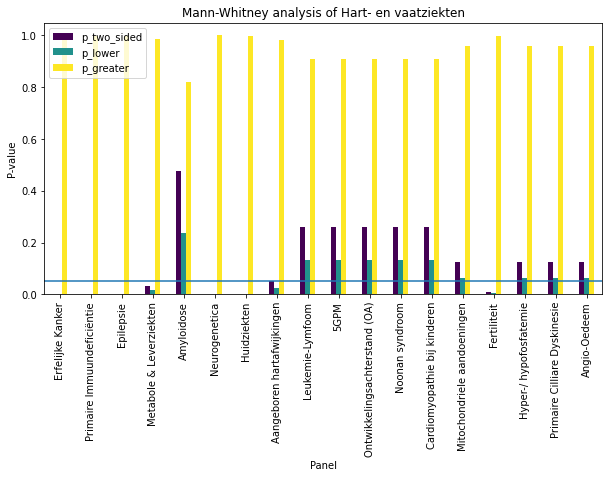

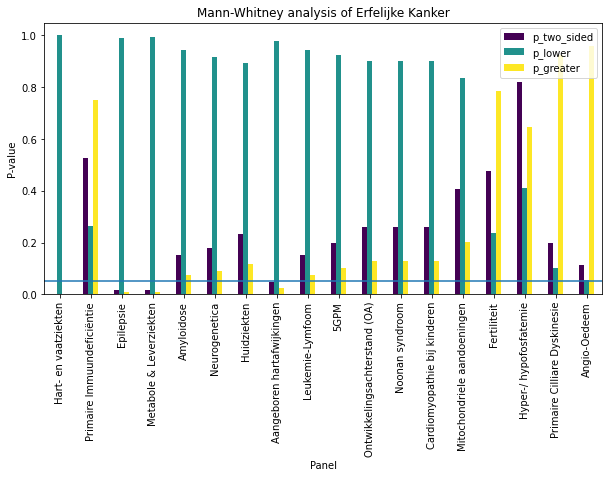

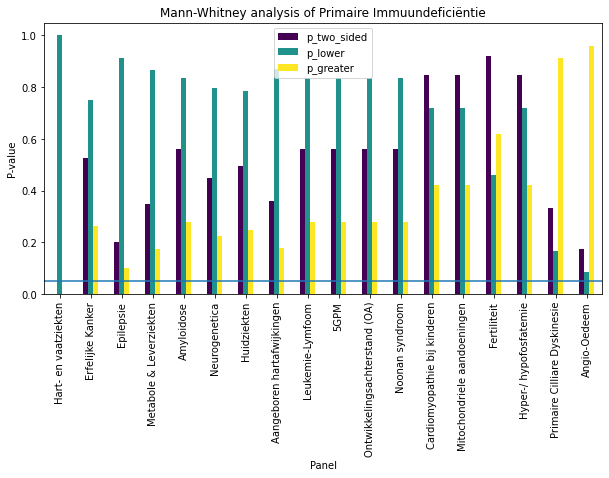

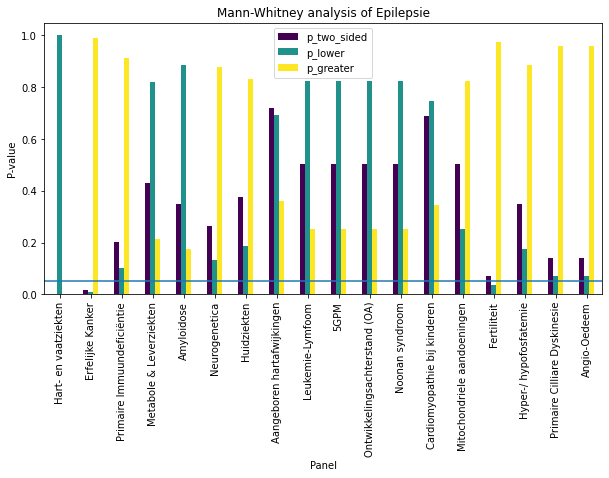

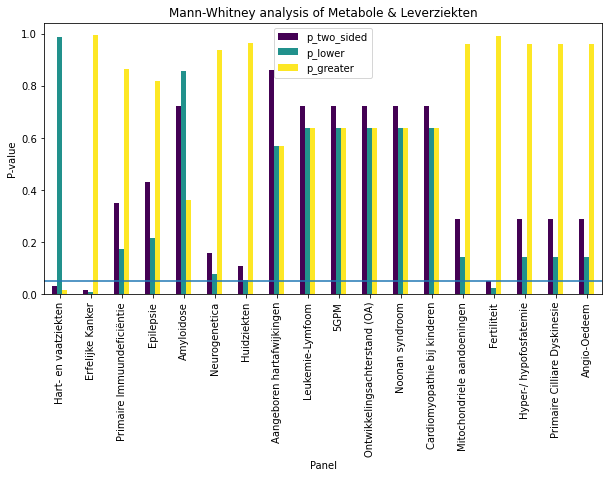

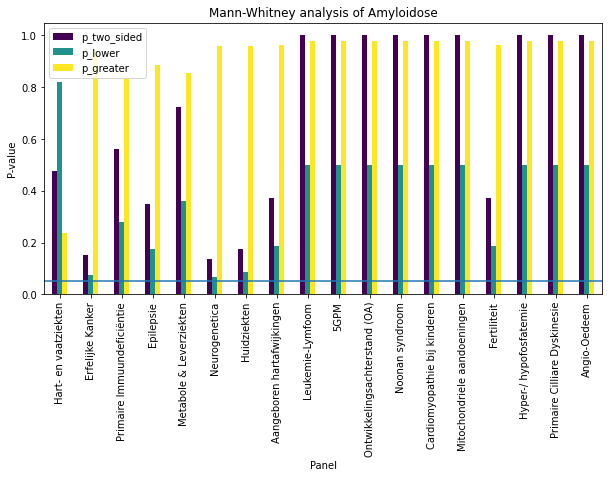

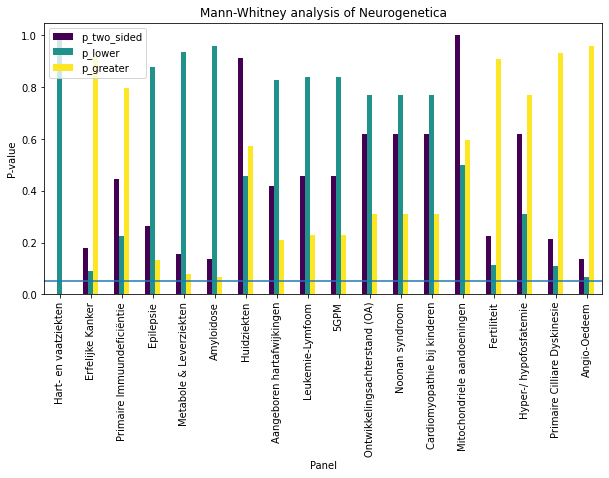

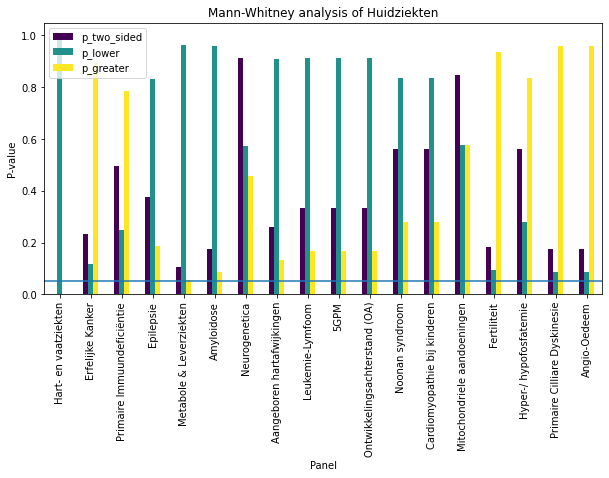

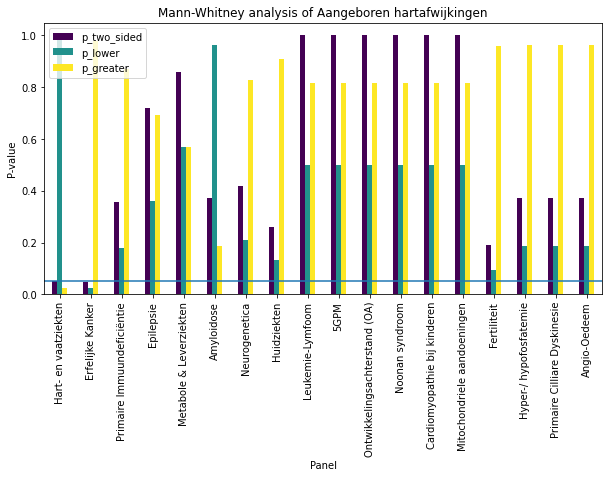

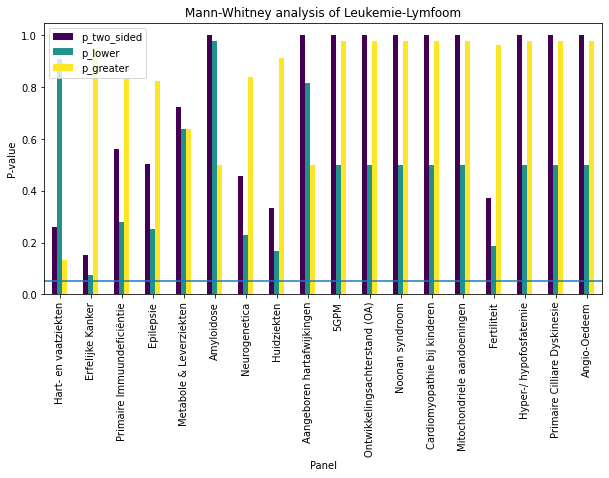

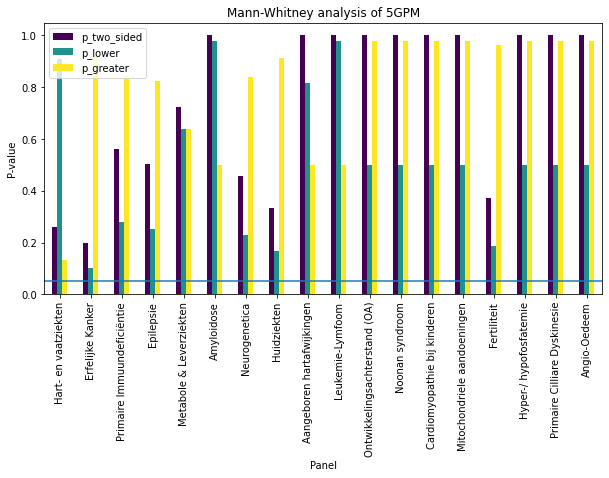

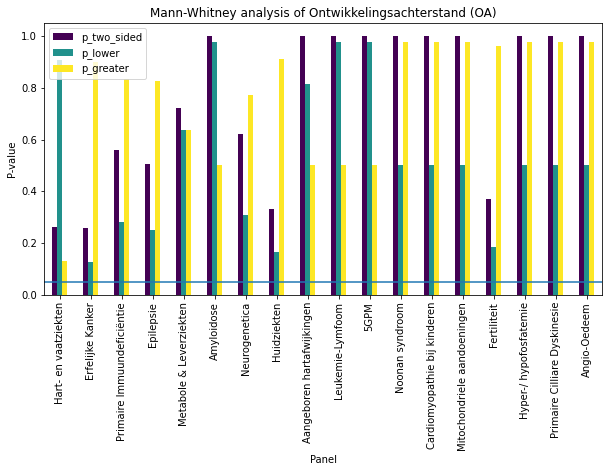

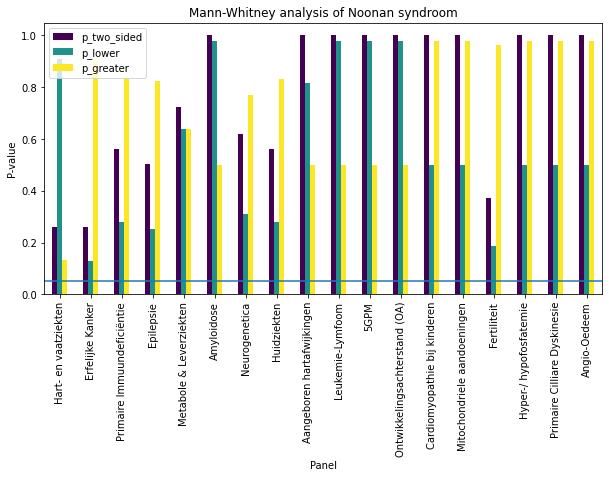

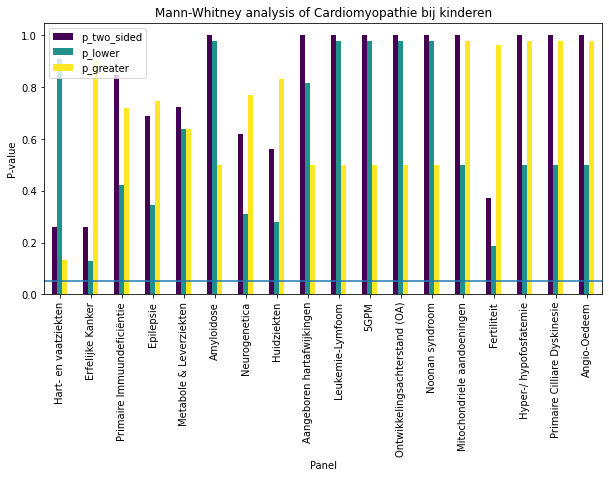

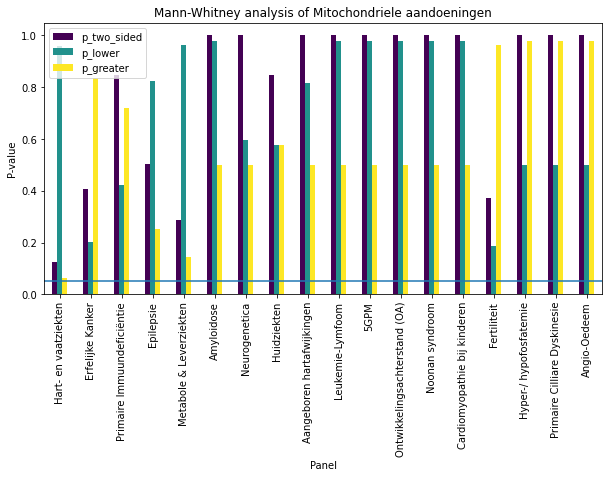

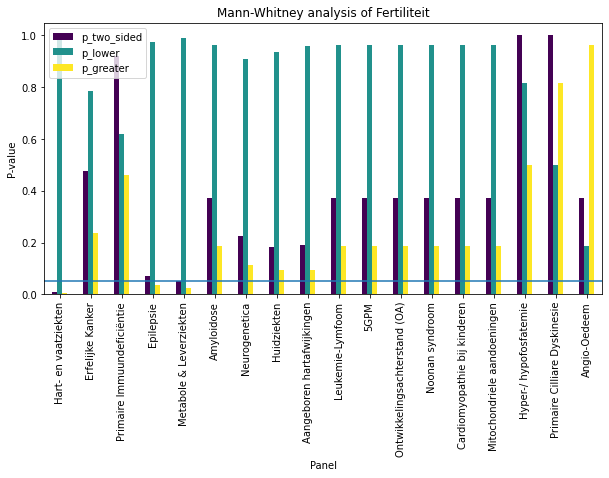

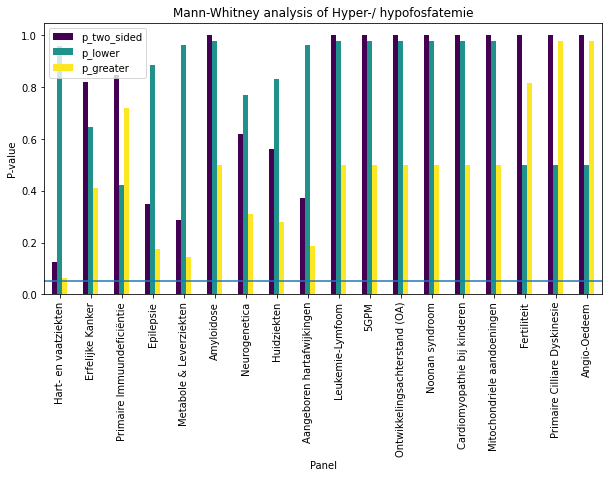

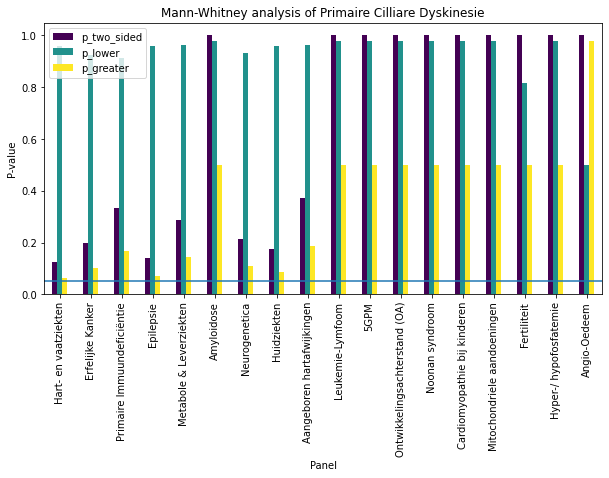

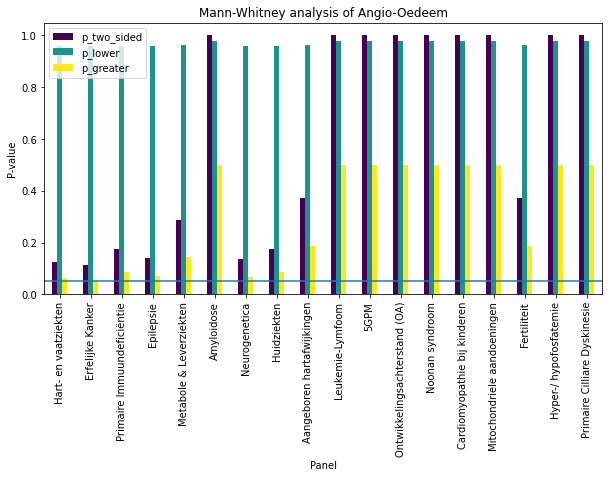

In [28]:
for category in wilcoxon_analysis['category'].unique():
    subset = wilcoxon_analysis[wilcoxon_analysis['category'] == category]
    ax = subset.plot.bar(x='compared_to',y=['p_two_sided', 'p_lower', 'p_greater'],
                         colormap='viridis',
                         figsize=(10,5),
                         title=f'Mann-Whitney analysis of {category}'
                        )
    ax.hlines(y=0.05,xmin=-10,xmax=100)
    ax.set_ylabel('P-value')
    ax.set_xlabel('Panel')

Now what do the plots above mean?

    - P_two_sided tests the null hypothesis that the distribution of title is different from the alternative. So when P is low, reject H0 (meaning there is a statisticial difference).
    - P_lower tests the alternative hypothesis that the median difference is negative. When P is low, reject H0, meaning that the median difference is negative. (If this value is low, it is statistically proven that x is lower than y)
    - P_higher tests the alternative hypothesis that the median difference is positive. When P is low, reject h0, meaning that the median difference is positive. (If this value is low, it is statistically proven that x is higher than y)

# From the Wilcoxon / Mannwhitney analysis
##### Hart- en vaatziekten
Every p_greater has a high P-value, indicating the category is not performing better than any other panel. Interestingly, Amyloidose, Leukemie-Lymfoom, 5GPM, OWA, Noonan syndroom, Cardiomyopathie bij kinderen, mitochondriele aandoeningen, hyper/hypofosfatemie, primaire cilliare dyskinesie en angio-oedeem also accepts H0 for two-sided and less, so it performs simular to them.
##### Erfelijke Kanker
Now quite the opposite of Hart- en vaatziekten, where p_lower accepts H0 except for maybe Angio-oedeem, meaning that everything is performing either worse or on par. Only Hart- en vaatziekten, epilepsie, metabole & leverziekten, aangeboren hartafwijkingen have some statistical proof of being better / worse than erfelijke kanker.
##### Primaire Immuundeficientie
Primaire immuundefientie is pretty much the average panel, only Hart- en vaatziekten performs statistically performs worse. Everything else is null hypothesis.
###### Angio-oedeem
Should be performing the best, a lot of high less p values is seen. But the null hypothesis for two-sided and greater can't be rejected in a single instance, so it might be performing better at sight, but it performs just average (which is good, this means CAPICE has a high average in the UMCG genepanels).


In [29]:
allvs1 = pd.DataFrame(columns=['two-sided', 'less', 'greater'])
for category in umcg_genepanel_analysis['category'].unique():
    if category == '5GPM':
        continue
    x = np.array(umcg_genepanel_analysis[umcg_genepanel_analysis['category'] == category]['avg_auc'])

    y = np.array(umcg_genepanel_analysis.where(
        ~(umcg_genepanel_analysis['category'] == category) & 
        ~(umcg_genepanel_analysis['category'] == '5GPM')
    ).dropna()['avg_auc'])
    output = {'category':'all',
              'compared_to':category,
              'two-sided':None,
              'less':None,
              'greater':None}
    for alternative in wilcoxon_alternatives:
        _, p = stats.mannwhitneyu(x, y, alternative=alternative)
        output[alternative] = p
    allvs1 = allvs1.append(
        pd.DataFrame(output, index=[0]), ignore_index=True
    )
allvs1        

,two-sided,less,greater,category,compared_to
0,8.387137e-08,4.193569e-08,1.000000,all,Hart- en vaatziekten
1,2.335297e-03,9.988650e-01,0.001168,all,Erfelijke Kanker
2,1.443765e-01,9.295787e-01,0.072188,all,Primaire Immuundeficiëntie
3,5.991497e-01,2.995749e-01,0.704180,all,Epilepsie
4,2.853821e-01,1.426910e-01,0.861318,all,Metabole & Leverziekten
5,2.889197e-01,1.444598e-01,0.863427,all,Amyloidose
6,4.634699e-01,7.714464e-01,0.231735,all,Neurogenetica
7,5.207033e-01,7.438423e-01,0.260352,all,Huidziekten
8,4.704156e-01,2.352078e-01,0.771085,all,Aangeboren hartafwijkingen
9,5.018088e-01,2.509044e-01,0.760216,all,Leukemie-Lymfoom


In [30]:
allvs1.to_csv('./not_saving_directory/previousmodelauc.csv', index=False)

Text(0.5, 0, 'Panel')

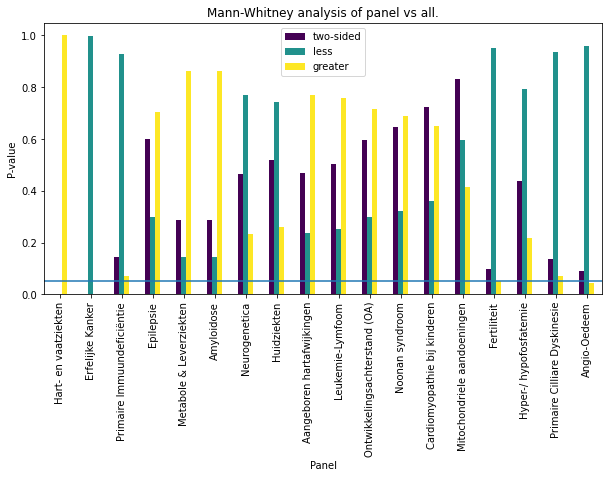

In [31]:
ax = allvs1.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all.')
ax.hlines(y=0.05,xmin=-10,xmax=100)
ax.set_ylabel('P-value')
ax.set_xlabel('Panel')

In [32]:
umcg_genepanel_analysis.where(~(umcg_genepanel_analysis['category'] == 'Hart- en vaatziekten') & 
                             ~(umcg_genepanel_analysis['category'] == '5GPM')).dropna()

,category,panel,min_auc,max_auc,avg_auc,std,med_auc,used%,used_n,genes_no_data,color,placeholder_x
78,Erfelijke Kanker,Endocrinologie-NET,0.500000,0.959184,0.833816,0.155455,0.906723,75,6/8,"[CDKN2B, CDKN2C]",#F06F1F,8.0
37,Primaire Immuundeficiëntie,Autoinflammatoir,0.500000,1.000000,0.862144,0.125045,0.883853,59,20/34,"[IL10, IL10RA, IL10RB, LACC1, OTULIN, POMP, PS...",#450A69,10.0
58,Epilepsie,Necrotiserende encefalopathie,0.862562,0.862562,0.862562,0.000000,0.862562,100,1/1,[],#70196E,11.0
48,Epilepsie,Focale epilepsie,0.500000,0.994318,0.875392,0.137229,0.940271,93,14/15,[NPRL2],#70196E,14.0
36,Primaire Immuundeficiëntie,CMC (Chronische mucocutane candidiasis),0.500000,1.000000,0.876051,0.190429,0.981250,71,5/7,"[IL17F, IL17RA]",#450A69,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...
91,Erfelijke Kanker,Longkanker,0.963235,0.963235,0.963235,0.000000,0.963235,100,1/1,[],#F06F1F,94.0
68,Fertiliteit,Congenitale Bilaterale Agenesie Vas Deferens (...,0.963502,0.963502,0.963502,0.000000,0.963502,50,1/2,[GPR64],#D54940,95.0
3,Neurogenetica,Neurodegeneratie met ijzerafzetting in de hers...,0.909926,1.000000,0.964537,0.031676,0.962963,100,9/9,[],#07051D,96.0
34,Primaire Immuundeficiëntie,B cel pathologie,0.914634,1.000000,0.966119,0.035738,0.976754,35,6/17,"[BLNK, CD40, CD79A, CD79B, CD81, ICOS, SH3KBP1...",#450A69,97.0


In [33]:
havd = output_genepanels['Hart- en vaatziekten']

In [34]:
lohavdg = [] # List Of Heart And Vascular Disease Genes
for key in havd.keys():
    if key.lower().startswith('dyslipid'):
        lohavdg = lohavdg + havd[key]
lohavdg = list(dict.fromkeys(lohavdg))

In [35]:
n_dislipid = pd.DataFrame(columns=['total', 'benign', 'malign'])
counting_dict = {
    'total':0,
    'benign':0,
    'malignant':0
}
for gene in lohavdg:
    subset = data[data['gene'] == gene]
    if subset.shape[0] > 0:
        counting_dict['total'] += subset['n_tot'].values[0]
        counting_dict['benign'] += subset['n_benign'].values[0]
        counting_dict['malignant'] += subset['n_malign'].values[0]
print(f"In dyslipidimie related genes, a total of {counting_dict['total']} variants are present, "
      f"of which {counting_dict['benign']} are benign and {counting_dict['malignant']} are malignant.")

In dyslipidimie related genes, a total of 8962 variants are present, of which 6950 are benign and 2012 are malignant.


In [36]:
data

,gene,auc,default_f1,default_recall,default_fpr,default_spec,optimal_c,optimal_auc,optimal_f1,optimal_recall,optimal_fpr,optimal_spec,n_tot,n_benign,n_malign
0,RDH12,0.839161,0.833333,0.909091,0.090909,0.909091,0.020,0.839161,0.833333,0.909091,0.090909,0.909091,24,13,11
1,EIF2AK4,0.981481,0.909091,1.000000,0.000000,1.000000,0.020,0.981481,0.909091,1.000000,0.000000,1.000000,32,27,5
2,EIF2AK3,0.966667,0.842105,1.000000,0.000000,1.000000,0.020,0.966667,0.842105,1.000000,0.000000,1.000000,53,45,8
3,PRKAG2,0.981203,0.761905,1.000000,0.000000,1.000000,0.020,0.981203,0.761905,1.000000,0.000000,1.000000,282,266,16
4,JAG1,0.925388,0.928994,0.987421,0.012579,0.987421,0.025,0.937810,0.940120,0.987421,0.012579,0.987421,320,161,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,FLG2,1.000000,1.000000,1.000000,0.000000,1.000000,0.020,1.000000,1.000000,1.000000,0.000000,1.000000,4,3,1
2803,ACOX2,1.000000,1.000000,1.000000,0.000000,1.000000,0.020,1.000000,1.000000,1.000000,0.000000,1.000000,2,1,1
2804,SLITRK4,1.000000,1.000000,1.000000,0.000000,1.000000,0.020,1.000000,1.000000,1.000000,0.000000,1.000000,3,2,1
2805,POGLUT1,1.000000,1.000000,1.000000,0.000000,1.000000,0.020,1.000000,1.000000,1.000000,0.000000,1.000000,2,1,1
